In [1]:
# Run this first!!!
from IPython.display import display, HTML

from __future__ import division
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import sys
sys.path.append('..')
import util
sys.path.append('../aho_merging')
from failure_chain_mc import FailureChain
sys.path.append('../common')
from sampling_misc import sample_stat_failure_chain_dist
from sampler import DepthSampler

## Motivation

In the last report I mentioned trying to come up with a Markov Chain that would help describe the distribution of the length of any given state's failure chain. Since last time I have realized that this is actually a very important thing to describe. Why?

1. It informs the probability of a state having a new thread as a child since for this to happen we must "fall" down the whole failure chain before matching at the root node.

2. It informs the offspring distribution because the number of possible children is equal to the length of the failure chain + 1.

For this reason, I spent this week trying to fix the Markov chain from last time (it wasn't completely right) and exploring if it is right/how it could be used.

## Fixing the Markov Chain

The probability transition matrix I gave in the last writeup was incorrect. In general, there were not enough boundary conditions. If one thinks about the recursion in terms on the matrix, any entry we are looking at depends on information to the left and above that entry. Therefore, there needs to be a boundary condition for both the left and top of the matrix. 

Let $\alpha$ be the probability that we are able to "move forward" from a state in the failure chain. This means that the letter we are currently considering is in the next set at that particular point in the generalized string.

Where $A_1$ is the next set (i.e. set of letters we will traverse the failure chain with), $A_2$ is the next set in $G$ at a particular point in the failure chain, and $p_\sigma$ is the probability of seeing letter $\sigma$ in any given set...

$$
\alpha = \sum_{\sigma \in \Sigma} P\left(\sigma \in A_2\right) \sum_{A_1 \subseteq \Sigma} P\left( \textrm{Pick } \sigma \in A_1\right) P(A_1 | A_1 \neq \emptyset)
$$

$$
= \sum_{\sigma \in \Sigma} p_\sigma \sum_{A_1 \subseteq \Sigma} \frac{1}{|A_1|} \frac{\left(\prod_{\sigma' \in A_1} p_{\sigma'}\right) \left(\prod_{\sigma' \in A_1^C} 1 - p_{\sigma'}\right)}{1 - \prod_{\sigma' \in \Sigma} 1 - p_{\sigma'}}
$$

Furthermore, we again need to consider the geometric random variable $L$ that represents how much we fall in the failure chain before a match. In particular $L \sim Geom_1(\alpha)$. With this...

$$
P\left(F_n = a | F_{n - 1} = b\right) = \begin{cases} 
      0 & a > b + 1 \\
      \alpha & a = 2, b = 0 \\
      1 - \alpha & a = 1, b = 0 \\
      (1 - \alpha)^b & a = 1 \\
      \left[\sum_{\ell = 1}^{b - 1} P\left(F_n = a - 1 | F_{n - 1} = b - \ell\right) P(L = \ell)\right]  + P(L \geq b) P(F_n = a - 1 | F_{n - 1} = 0) & \textrm{else}
   \end{cases}
$$

I was able to build this via dynamic programming and miraculously it looks like it is actually a valid Markov Chain. 

## Does there seem to be a Stationary Distribution in the Model?

Ideally we would want there to be a stationary distribution so that we can draw on these probabilities in our other calculations. We know that if there is a stationary distribution it will be unique because the chain is irreducible. To check whether there is a stationary distribution, I will look at the distribution after the chain has ran for a long time and collect data. I will do this two times (but vary how long we let the chain run for) and see if the two supposed stationary distributions are the same (we know if one exists it must be unique).

In [2]:
def compare_stat_dists(depth1, depth2, num_samples, probs):
    fc = FailureChain(probs)
    stat1 = fc.get_stationary_dist(depth1, num_samples)
    print 'Distribution after %d runs:\t' % depth1,
    print stat1
    stat2 = fc.get_stationary_dist(depth2, num_samples)
    print 'Distribution after %d runs:\t' % depth2,
    print stat2
    print 'Relative Difference From 1st:\t'
    print [(stat1[i] - stat2[i])/stat1[i] 
           if i < len(stat1) and i < len(stat2) else float('inf')
           for i in range(max(len(stat1), len(stat2)))]

In [3]:
DEPTH1 = 100
DEPTH2 = 200
NUM_SAMPLES = 10000
PROBS = [0.25, 0.5, 0.75, 0.3]

compare_stat_dists(DEPTH1, DEPTH2, NUM_SAMPLES, PROBS)

Distribution after 100 runs:	[0.1877, 0.3887, 0.2935, 0.1071, 0.0201, 0.0025, 0.0004]
Distribution after 200 runs:	[0.1922, 0.3878, 0.2876, 0.1084, 0.0214, 0.0023, 0.0003]
Relative Difference From 1st:	
[-0.023974427277570612, 0.002315410342166226, 0.02010221465076648, -0.012138188608776803, -0.06467661691542284, 0.08000000000000003, 0.2500000000000001]


Looks pretty close to me! I am thinking that there is one. We basically have a finite state space here because it is really unlikely that we keep going. The one case where this is not true is if we have a letter that will always appear in a set. In this case there will be no stationary distribution since we go off to infinity.

There is a theorem that says this will have a stationary distribution if there is one state that is positive recurrent (expected value of next visit time is finite). This seems like it should always be true since all states have some positive probability of going to state $(1)$. Might need to try to prove this later.

## Comparing Model against Truth

Now I would like to simulate the actual algorithm and the model to see if they align closely. First I will look at the distribution in states asymptotically to see if they are close.

In [4]:
def compare_stat_dists_against_real(num_samples, probs, depth):
    fc = FailureChain(probs)
    theoretical = fc.get_stationary_dist(depth, num_samples)
    print 'Theoretical: \t', theoretical
    sampled = sample_stat_failure_chain_dist(num_samples, probs, depth)
    print 'Sampled: \t', sampled
    s_len, t_len = len(sampled), len(theoretical)
    print 'Relative Difference: '
    print [(sampled[i] - theoretical[i]) / theoretical[i] 
           if i < s_len and i < t_len else float('inf')
           for i in range(max(s_len, t_len))]

In [6]:
NUM_SAMPLES = 1000
PROBS = [0.25, 0.5, 0.75, 0.3]
DEPTH = 50

compare_stat_dists_against_real(NUM_SAMPLES, PROBS, DEPTH)

Theoretical: 	[0.199, 0.392, 0.289, 0.101, 0.016, 0.003]
Sampled: 	[0.247, 0.306, 0.218, 0.125, 0.062, 0.024, 0.009, 0.006, 0.002, 0.001]
Relative Difference: 
[0.2412060301507537, -0.21938775510204087, -0.24567474048442903, 0.23762376237623756, 2.875, 7.0, inf, inf, inf, inf]


Although the two distributions look similar, there is definitely an obvious difference between them. For one thing it seems that the mass in the sampled distribution is pushed more over to the left (closer to state $(1)$). However, at the same time, there is more positive probability of going to higher states.

To get a better understanding I also plotted a lot of individual realizations together to see if any insight could be gleaned.

In [4]:
def compare_trends(probs, depth, realizations):
    fc = FailureChain(probs)
    ds = DepthSampler(probs, depth)
    depth_list = range(depth + 1)
    avg_theoretical = None
    avg_sampled = None
    plt.figure(figsize=(14, 6))
    for _ in xrange(realizations):
        theoretical = fc.get_realization_path(depth)
        sampled = ds.draw_samples(1, ['failure_chain_path'])['failure_chain_path'].tolist()
        plt.plot(depth_list, theoretical, 'b-', alpha=0.05)
        plt.plot(depth_list, sampled, 'r-', alpha=0.05)
        if avg_theoretical is None:
            avg_theoretical = theoretical
            avg_sampled = sampled
        else:
            avg_theoretical = [avg_theoretical[i] + theoretical[i] for i in range(len(theoretical))]
            avg_sampled = [avg_sampled[i] + sampled[i] for i in range(len(theoretical))]
    avg_theoretical = [val / realizations for val in avg_theoretical]
    avg_sampled = [val / realizations for val in avg_sampled]
    plt.plot(depth_list, avg_theoretical, 'b-', alpha=1)
    plt.plot(depth_list, avg_sampled, 'r-', alpha=1)
    plt.title('Single Path Realizations')
    plt.ylabel('Failure Chain Length')
    plt.xlabel('Depth')
    blue_patch = mpatches.Patch(color='blue', label='Theoretical')
    red_patch = mpatches.Patch(color='red', label='Sampled')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

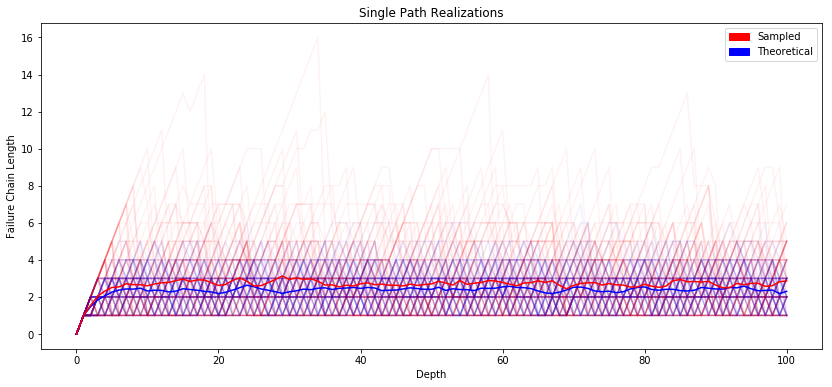

In [5]:
PROBS = [0.25, 0.5, 0.75, 0.3]
DEPTH = 100
REALIZATIONS = 100

compare_trends(PROBS, DEPTH, REALIZATIONS)

In the above plot, the lighter lines are single realizations, whereas the solid line is the average of all the realizations. One can see the average is consistently higher with the sampled. The reasons for this looks to be that there is the possibility of the sampled paths to visit much higher states.

## Going Forward

There are two main things going forward: figuring out what is wrong with this model and seeing if we can make it match reality and figuring out if there is a way to analytically determine the stationary distribution (this is asssuming there is one, which it looks like there is).

Potential problems with the model...

1. My value of $\alpha$ is wrong.

2. There is some assumption I am making that is violated. Perhaps there is a relationship between states that this model does not consider.